In [1]:
import numpy as np
from scipy.stats import binom
from scipy.stats import truncnorm
from scipy.stats import gamma

In [2]:
# Parameters 

h = 1/7
pho = 2/3
g = 2/3
R = 19
T = 7*R

In [3]:
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [4]:
#  Effective Sampling Size 

def ESS(W):                 # Takes an array as argument
    return 1/np.sum(W**2)

In [5]:
# Mutation transition

def mutation(theta, X):
    #
    X_new = X
    S, E, I, R =  X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3]  
    M = theta[:16].reshape(4,4)
    betas = 1/8000 * np.dot(M, I)
    B = np.random.binomial(S, np.ones(4)-np.exp(-h*betas)) 
    C = np.random.binomial(E, 1-np.exp(-h*pho)) 
    D = np.random.binomial(I, 1-np.exp(-h*g)) 
    S_new = S - B
    E_new = E + B - C
    I_new = I + C - D
    R_new = R + D
    X_new[:, 0], X_new[:, 1], X_new[:, 2], X_new[:, 3] = S_new, E_new, I_new, R_new
    return X_new

In [6]:
# Likelihood of y knowing theta

def log_f(y, theta, X):
    C = np.zeros((7,4))
    for i in range(7):
        X = mutation(theta, X)
        C[i] = np.random.binomial(X[:, 1], 1-np.exp(-h*pho))
    return(np.log(binom.pmf(y, np.sum(C, axis=0), theta[16:])+1.5))

In [7]:
# Initial settings
X1 = np.array([948, 0, 1, 0])
X2 = np.array([1689, 0, 1, 0])
X3 = np.array([3466, 0, 1, 0])
X4 = np.array([1894, 0, 1, 0])

def BootstrapFilter(y, theta, ESS_min, N, R=19):
    X = np.array([[X1, X2, X3, X4] for i in range(N)]) 
    w_init = np.zeros((N, 4))
    X_all = np.array([X for r in range(R+1)])
    for n in range(N):
        w_init[n] = log_f(y[0], theta, X[n])
    W_init = np.zeros((N, 4))
    for n in range(N):
        W_init[n] = np.divide(w_init[n], np.sum(w_init, axis=0))
    W = W_init
    w = w_init
    X_all[1] = X
    for r in range(R):
        w_hats = np.zeros((N,4))
        for k in range(4):
            if ESS(W[:, k]) < ESS_min:
                A = np.random.choice(np.arange(0, N), size=N, p=W[:, k])
                w_hat = np.zeros(N)
            else:
                A = np.arange(0, N)
                w_hat = w[:, k]
            for n in range(N):
                X[n][k] = X[A[n]][k]
            w_hats[:, k] = w_hat
        for n in range(N):
            w[n] = w_hats[n]+log_f(y[r], theta, X[n])
        for n in range(N):
            W[n] = np.divide(w[n], np.sum(w, axis=0))
        X_all[r+1] = X
    return(X_all)

In [8]:
theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)
Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
X_all = BootstrapFilter(Y, theta, 999, 1000, R=19)

In [9]:
print(X_all[8])

[[[  58  203  267  421]
  [  28  325  423  914]
  [  30  527  873 2037]
  [   4  224  418 1249]]

 [[  55  214  250  430]
  [  44  357  462  827]
  [  32  655  918 1862]
  [   7  311  466 1111]]

 [[  52  208  265  424]
  [  35  328  454  873]
  [  20  566  872 2009]
  [   5  285  444 1161]]

 ...

 [[  38  235  274  402]
  [  28  321  416  925]
  [  30  555  887 1995]
  [   5  242  448 1200]]

 [[  46  229  260  414]
  [  27  346  482  835]
  [  25  606  929 1907]
  [   3  257  466 1169]]

 [[  47  214  238  450]
  [  41  339  433  877]
  [  33  592  903 1939]
  [   5  296  485 1109]]]


In [10]:
def log_prior(theta):
    log_prior = 0
    for i in range(16):
        if gamma.pdf(theta[i], a=5, loc=0, scale=1)==0:
            return -100000
        else:
            log_prior = log_prior + np.log(gamma.pdf(theta[i], a=5, loc=0, scale=1))
    for i in range(4):
        if truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5)==0:
            return -10000
        else:
            log_prior = log_prior + np.log(truncnorm.pdf(theta[16+i], a=0, b=1, loc=0.5, scale=0.5))
    return log_prior

In [11]:
def LogL(y, theta, X):
    L = np.zeros(4)
    for r in range(R):
        S = 0
        for n in range(len(X[r])):
            x = X[r][n]
            S = S + np.exp(log_f(y[r], theta, x)) - 1.5
        for k in range(4):
            if S[k] == 0:
                L[k] = - 100000
            else:
                L[k] = L[k] + np.log(S[k]) - len(X[r])
    return L+log_prior(theta)

In [12]:
def PMMH(y, ESS_min, Nx, Nt, R=19):
    
    theta = np.concatenate((np.random.gamma(5, 1, 16), get_truncated_normal(mean=0.5, sd=0.5, low=0, upp=1).rvs(4)), axis=None)    
    thetas = np.array([theta for i in range(Nt)])
    X = BootstrapFilter(y, theta, ESS_min, Nx, R=19)
    L = LogL(y, theta, X)
    
    for n in range(1, Nt):
        theta_new =  np.concatenate((get_truncated_normal(mean=theta[:16], sd=0.15, low=0, upp=np.inf).rvs(), get_truncated_normal(mean=theta[16:], sd=0.15, low=0, upp=1).rvs()), axis=None)
        #print(theta_new)
        X_new = BootstrapFilter(y, theta_new, ESS_min, Nx, R=19)
        L_new = LogL(y, theta_new, X_new)
        v = L_new - L
        #print(L_new[0], L[0], v[0])
        #print(L[2], v[2], X_new[:, :, 2])
        
        for k in range(4):      
            u = np.random.uniform()
            if np.log(u)<v[k]:
                L[k] = L_new[k]
                thetas[n, 4*k:4*k+4] = theta_new[4*k:4*k+4]
                thetas[n, 16+k] = theta_new[16+k]
                theta[4*k:4*k+4] = theta_new[4*k:4*k+4]
                theta[16+k] = theta_new[16+k]
                
            else:
                thetas[n, 4*k:4*k+4] = theta[4*k:4*k+4]
                thetas[n, 16+k] = theta[16+k]   
                
    return thetas

In [1]:
# Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])
# PMMH(Y, 999, 25, 10000, R=19)

Run PMMH 1/10
Run PMMH 2/10
Run PMMH 3/10
Run PMMH 4/10
Run PMMH 5/10
Run PMMH 6/10
Run PMMH 7/10
Run PMMH 8/10
Run PMMH 9/10
Run PMMH 10/10


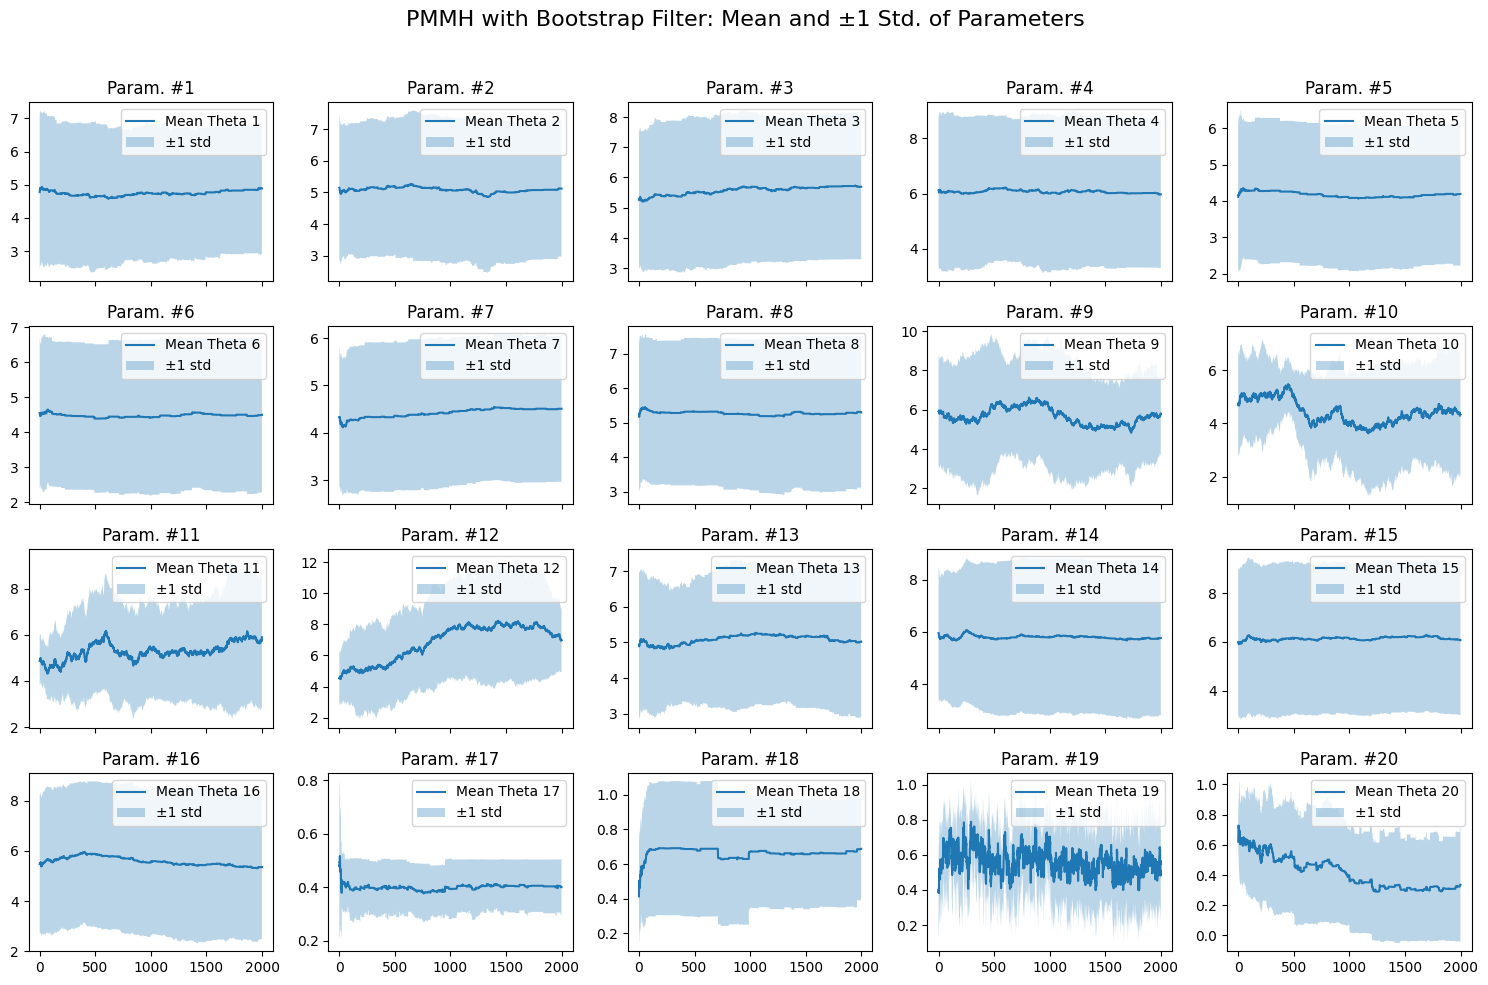

In [13]:
import numpy as np
import matplotlib.pyplot as plt

############################
# Predefined functions assumed to be available:
############################
# - ESS(W)
# - mutation(theta, X)
# - log_f(y, theta, X)
# - BootstrapFilter(y, theta, ESS_min, N, R=19)
# - log_prior(theta)
# - LogL(y, theta, X)
# - PMMH(y, ESS_min, Nx, Nt, R=19)
#
# These functions are assumed to be already defined
# in the environment.
############################

def run_multiple_pmmh(Y, ESS_min, Nx, Nt, R=19, n_runs=10):
    """
    Runs the PMMH function `n_runs` times and returns:
    - thetas_runs: Array of parameters (n_runs, Nt, dim_theta)
    - mean_thetas: Point-wise mean across `n_runs` (Nt, dim_theta)
    - std_thetas: Point-wise standard deviation across `n_runs` (Nt, dim_theta)
    """
    # Store all theta samples for each run
    all_thetas_runs = []

    for i in range(n_runs):
        print(f"Run PMMH {i+1}/{n_runs}")
        thetas = PMMH(Y, ESS_min, Nx, Nt, R=R)
        all_thetas_runs.append(thetas)

    # Convert to array (shape = (n_runs, Nt, dim_theta))
    all_thetas_runs = np.array(all_thetas_runs)

    # Compute mean (shape = (Nt, dim_theta)) and 
    # standard deviation (shape = (Nt, dim_theta))
    mean_thetas = np.mean(all_thetas_runs, axis=0)
    std_thetas  = np.std(all_thetas_runs, axis=0)
    
    return all_thetas_runs, mean_thetas, std_thetas


############################
# Example of usage
############################
if __name__ == "__main__":

    # Data Y
    Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])


    # PMMH parameters
    ESS_min = 999
    Nx = 50
    Nt = 2000
    R = 19
    
    # Number of desired runs
    n_runs = 10

    # Perform multiple runs
    thetas_runs, mean_thetas, std_thetas = run_multiple_pmmh(Y, ESS_min, Nx, Nt, R, n_runs)

    # thetas_runs has shape (n_runs, Nt, dim_theta)
    # mean_thetas and std_thetas have shape (Nt, dim_theta)
    # where dim_theta = 20 in your case (16 gamma + 4 truncnorm).

    # --- VISUALIZATION ---
    # Plot the mean chain and ±1 standard deviation
    # for each dimension (each parameter).
    
    dim_theta = mean_thetas.shape[1]  # should be 20
    iterations = np.arange(Nt)
    
    # For better readability, use a subplot (e.g., 4x5 if dim_theta=20).
    nrow, ncol = 4, 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10), sharex=True)
    axes = axes.flatten()  # Flatten for easier iteration
    
    for i in range(dim_theta):
        ax = axes[i]
        
        # Plot the mean
        ax.plot(iterations, mean_thetas[:, i], label=f"Mean Theta {i+1}")
        
        # Plot ±1 standard deviation range
        lower = mean_thetas[:, i] - std_thetas[:, i]
        upper = mean_thetas[:, i] + std_thetas[:, i]
        ax.fill_between(iterations, lower, upper, alpha=0.3, label="±1 std")
        
        ax.set_title(f"Param. #{i+1}")
        ax.legend(loc="upper right")
        
    plt.suptitle("PMMH with Bootstrap Filter: Mean and ±1 Std. of Parameters", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

############################
# Predefined functions assumed to be available:
############################
# - ESS(W)
# - mutation(theta, X)
# - log_f(y, theta, X)
# - BootstrapFilter(y, theta, ESS_min, N, R=19)
# - log_prior(theta)
# - LogL(y, theta, X)
# - PMMH(y, ESS_min, Nx, Nt, R=19)
#
# These functions are assumed to be already defined
# in the environment.
############################

def run_multiple_pmmh(Y, ESS_min, Nx, Nt, R=19, n_runs=10, burnin=1000):
    """
    Runs the PMMH function `n_runs` times and returns:
    - thetas_runs: Array of parameters (n_runs, Nt, dim_theta)
    - mean_thetas: Point-wise mean across `n_runs` (Nt, dim_theta)
    - std_thetas: Point-wise standard deviation across `n_runs` (Nt, dim_theta)
    """
    # Store all theta samples for each run
    all_thetas_runs = []

    for i in range(n_runs):
        print(f"Run PMMH {i+1}/{n_runs}")
        thetas = PMMH(Y, ESS_min, Nx, Nt, R=R)
        all_thetas_runs.append(thetas[burnin:])

    # Convert to array (shape = (n_runs, Nt, dim_theta))
    all_thetas_runs = np.array(all_thetas_runs)

    # Compute mean (shape = (Nt, dim_theta)) and 
    # standard deviation (shape = (Nt, dim_theta))
    mean_thetas = np.mean(all_thetas_runs, axis=0)
    std_thetas  = np.std(all_thetas_runs, axis=0)
    
    return all_thetas_runs, mean_thetas, std_thetas


############################
# Example of usage
############################
if __name__ == "__main__":

    # Data Y
    Y = np.array([[0,0,1,1],[0,2,6,1],[0,2,4,2],[23,73,63,11],[63,208,173,41],[73,207,171,27],[66,150,143,7],[26,40,87,29],[17,18,33,12],[3,4,13,6],[2,6,16,5],[1,6,11,3],[0,1,6,5],[0,2,2,2],[0,1,3,0],[0,1,4,6],[0,1,3,0],[2,1,7,1], [1,1,6,2]])


    # PMMH parameters
    ESS_min = 999
    Nx = 50
    Nt = 2000
    R = 19
    
    # Number of desired runs
    n_runs = 10

    # Perform multiple runs
    thetas_runs, mean_thetas, std_thetas = run_multiple_pmmh(Y, ESS_min, Nx, Nt, R, n_runs)

    # thetas_runs has shape (n_runs, Nt, dim_theta)
    # mean_thetas and std_thetas have shape (Nt, dim_theta)
    # where dim_theta = 20 in your case (16 gamma + 4 truncnorm).

    # --- VISUALIZATION ---
    # Plot the mean chain and ±1 standard deviation
    # for each dimension (each parameter).
    
    dim_theta = mean_thetas.shape[1]  # should be 20
    iterations = np.arange(Nt)
    
    # For better readability, use a subplot (e.g., 4x5 if dim_theta=20).
    nrow, ncol = 4, 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10), sharex=True)
    axes = axes.flatten()  # Flatten for easier iteration
    
    for i in range(dim_theta):
        ax = axes[i]
        
        # Plot the mean
        ax.plot(iterations, mean_thetas[:, i], label=f"Mean Theta {i+1}")
        
        # Plot ±1 standard deviation range
        lower = mean_thetas[:, i] - std_thetas[:, i]
        upper = mean_thetas[:, i] + std_thetas[:, i]
        ax.fill_between(iterations, lower, upper, alpha=0.3, label="±1 std")
        
        ax.set_title(f"Param. #{i+1}")
        ax.legend(loc="upper right")
        
    plt.suptitle("PMMH with Bootstrap Filter: Mean and ±1 Std. of Parameters", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Run PMMH 1/10


KeyboardInterrupt: 